# Big Data Project - Amazon Reviews

By Siqi Jiang, Lingchen Kong, Haofu Wu, Guangzhe Zhu 

## Import Spark

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("project`").getOrCreate()

In [2]:
spark

## Data Preparation

In [3]:
import pandas as pd
import numpy as np
import pyspark.sql.functions as F

In [4]:
# set pandas display max length
pd.options.display.max_colwidth = 100

In [5]:
# import review dataset
reviews = spark.read.parquet("s3://amazon-reviews-pds/parquet")

In [6]:
# show first 5 lines in 
reviews.limit(5).toPandas()

/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year,product_category
0,US,15008761,R3RXRGB5VRJCZL,1591397839,820845987,The Ultimate Question: Driving Good Profits and True Growth,4,0,0,N,Y,A Useful and Straightforward Tool,"We currently use the Net Promoter Score concept at the Glass Doctor, but I wanted to get a bette...",2010-10-25,2010,Books
1,US,51736210,R1FNQ7EQ9RAFON,0876379978,271304978,How to Make Money in Coins Right Now (House of collectibles),5,23,38,N,N,TRAVERS IS A GENIUS!,but there is a catch. Yes I am following Traver's advice. I don't plan on making a cent for 6 mo...,2000-07-17,2000,Books
2,US,39757245,R1YOWU9YS3IONV,0307457052,464955579,The Miracle of Mercy Land: A Novel,4,0,0,N,N,Intriguing Read!,"River Jordan's fourth novel opens with the birth of Mercy Land to hard-working, faithful parents...",2010-10-25,2010,Books
3,DE,53079534,R39KAX81XDHQVM,0380788624,555229230,Cryptonomicon,1,2,6,N,N,"Pretentious, ponderous, and self-absorbed",I was only able to get to page 64 of this clunker. Genitalia is mentioned often; the author eve...,2000-07-17,2000,Books
4,US,50143808,RR7QWQHGKU3K7,0307270661,920731407,Life Would Be Perfect If I Lived in That House,5,0,1,Y,N,Witty Original Book,"I really liked Megan Daum's previous book so I was eager to read this one. Daum has a readable,...",2010-10-25,2010,Books


In [9]:
# count the row number of the dataset
reviews.count()

160796570

In [7]:
# View the schema of the dataset
reviews.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- product_category: string (nullable = true)



In [36]:
# show the row number of different marketplaces
print('US', reviews.filter("marketplace = 'US'").count())
print('DE', reviews.filter("marketplace = 'DE'").count())
print('FR', reviews.filter("marketplace = 'FR'").count())
print('UK', reviews.filter("marketplace = 'UK'").count())
print('JP', reviews.filter("marketplace = 'JP'").count())

US 157893444
DE 679121
FR 254080
UK 1707494
JP 262431


In [42]:
# check the number of product category
reviews.select('product_category').distinct().count()

43

In [44]:
# show all product category
reviews.select('product_category').distinct().show(43)

+--------------------+
|    product_category|
+--------------------+
|                  PC|
|             Kitchen|
|                Home|
|            Wireless|
|               Video|
| Digital_Video_Games|
|Digital_Video_Dow...|
|             Luggage|
|              Sports|
|         Video_Games|
|  Mobile_Electronics|
|  Home_Entertainment|
|Digital_Ebook_Pur...|
|                Baby|
|             Apparel|
|    Major_Appliances|
|             Grocery|
|               Tools|
|         Electronics|
|            Outdoors|
|     Lawn_and_Garden|
|    Home_Improvement|
|        Pet_Products|
|          Automotive|
| Musical_Instruments|
|               Books|
|    Digital_Software|
|Health_&_Personal...|
|               Music|
|           Furniture|
|Personal_Care_App...|
|            Software|
|         Mobile_Apps|
|Digital_Music_Pur...|
|              Camera|
|               Shoes|
|     Office_Products|
|           Gift_Card|
|             Jewelry|
|             Watches|
|          

### US DATA

In [8]:
# select review for only US market
us_reviews = reviews.filter("marketplace = 'US'").cache()

In [10]:
# register for US market reviews' sql table
us_reviews.createOrReplaceTempView('ustbl')

In [11]:
# check the row number of US market reviews
spark.sql("""select count(*) from ustbl""").show()

+---------+
| count(1)|
+---------+
|157893444|
+---------+



## Part 1: General Exploration

#### Part a: Review trend in 10 years (2006-2015) 

In [145]:
from pyspark.sql.functions import year,month
from pyspark.sql.functions import col
us_reviews = us_reviews.withColumn("month",month(col("review_date")))

In [146]:
# count review amout by year and month
us_reviews_count = us_reviews.groupBy("year","month").agg(F.count("*").alias("count")).orderBy("year","month").toPandas()
us_reviews_count['year-month'] = pd.to_datetime(us_reviews_count[['year', 'month']].assign(Day=1))

/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [147]:
ten_year_reviews = us_reviews_count[(us_reviews_count["year"]>= 2006)&(us_reviews_count["year"]<= 2015)]

In [148]:
ten_year_reviews.head(10)

,year,month,count,year-month
125,2006,1,130658,2006-01-01
126,2006,2,133788,2006-02-01
127,2006,3,164052,2006-03-01
128,2006,4,61715,2006-04-01
129,2006,5,104536,2006-05-01
130,2006,6,112454,2006-06-01
131,2006,7,132885,2006-07-01
132,2006,8,131971,2006-08-01
133,2006,9,82098,2006-09-01
134,2006,10,83790,2006-10-01


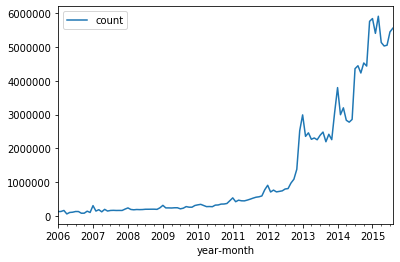

In [150]:
# plot
import matplotlib.pyplot as plt

ax = plt.gca()

ten_year_reviews.plot(kind='line',x='year-month',y='count',ax=ax)

plt.show()

#### Part b: Verified Purchase Reviews in 10 years (2006-2015)

In [151]:
# aggreagate verified_purchase
us_reviews_verified = us_reviews.groupBy("year","month","verified_purchase").agg(F.count("*").alias("vcount")).orderBy("year","month","verified_purchase")

In [152]:
# convert to pandas
verified_review = us_reviews_verified.toPandas()

/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [153]:
# show first lines of the data
verified_review.head()

,year,month,verified_purchase,vcount
0,1995,6,N,2
1,1995,7,N,23
2,1995,8,N,22
3,1995,9,N,28
4,1995,10,N,46


In [154]:
# count total verified purchase reviews by month and year
verified_review2 = verified_review.groupby(["year", "month"], sort=False)["vcount"].sum().reset_index(name ='Total_Amount')

In [155]:
# merge datasets
verified_total = pd.merge(verified_review, verified_review2, on=['year', 'month'], how='inner')

In [156]:
# calculate the percentage of verified purchase reviews
verified_total['verified_percentage'] = verified_total.apply (lambda row: row.vcount/row.Total_Amount, axis=1)

In [157]:
# create year-month colunmn
verified_total['year-month'] = pd.to_datetime(verified_total[['year', 'month']].assign(Day=1))

In [158]:
# subset verified purchase for 2006-2015
verified_total_Y = verified_total[(verified_total["year"]>= 2006)&(verified_total["year"]<= 2015)&(verified_total["verified_purchase"] == "Y")]

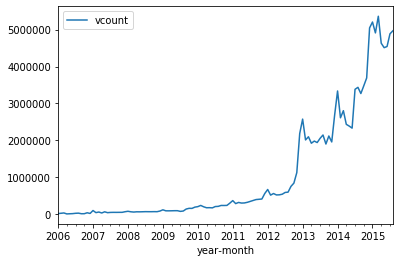

In [159]:
# gca stands for 'get current axis'
ax = plt.gca()

verified_total_Y.plot(kind='line',x='year-month',y='vcount',ax=ax)

plt.show()

#### Part c: Rating Difference Between Verified Purchase and Non-verified Purchase in 10 years (2006-2015)

In [162]:
# count total review and average rating for verified purchase and non-verified pruchase
verified_rating = spark.sql("""select verified_purchase, avg(star_rating), count(*) as count
from ustbl
where year > 2005
group by verified_purchase
order by count
""").toPandas()

In [163]:
verified_rating

,verified_purchase,avg(star_rating),count
0,N,4.093262,28389513
1,Y,4.233208,122207606


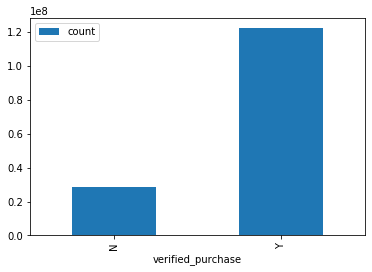

In [164]:
# a simple bar plot
verified_rating.plot(kind='bar',x='verified_purchase',y='count')

#### Part d: Vine Program Purchase Reviews in 10 years (2006-2015)

In [165]:
# aggreagate vine_purchase
us_reviews_vine = us_reviews.groupBy("year","month","vine").agg(F.count("*").alias("vcount")).orderBy("year","month","vine").toPandas()

In [166]:
# count total vine purchase reviews by month and year
vine_review = us_reviews_vine.groupby(["year", "month"], sort=False)["vcount"].sum().reset_index(name ='Total_Amount')

In [167]:
# merge datasets
vine_total = pd.merge(us_reviews_vine, vine_review, on=['year', 'month'], how='inner')

In [168]:
# calculate the percentage of vine purchase reviews and create year-month column
vine_total['vine_percentage'] = verified_total.apply (lambda row: row.vcount/row.Total_Amount, axis=1)
vine_total['year-month'] = pd.to_datetime(verified_total[['year', 'month']].assign(Day=1))

In [169]:
# subset vine purchase for 2006-2015
vine_total_Y = vine_total[(vine_total["year"]>= 2006)&(vine_total["year"]<= 2015)&(vine_total["vine"] == "Y")]

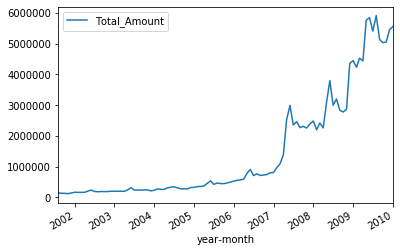

In [170]:
# gca stands for 'get current axis'
ax = plt.gca()

vine_total_Y.plot(kind='line',x='year-month',y='Total_Amount',ax=ax)

plt.show()

#### Part e: Rating Difference Between Vine Purchase and Non-vine Purchase in 10 years (2006-2015)

In [171]:
# count total review and average rating for vine purchase and non-vine pruchase
vine_rating = spark.sql("""select vine, avg(star_rating), count(*) as count
from ustbl
where year > 2005
group by vine
order by count
""").toPandas()

In [172]:
vine_rating

,vine,avg(star_rating),count
0,Y,4.083618,673205
1,N,4.207380,149923914


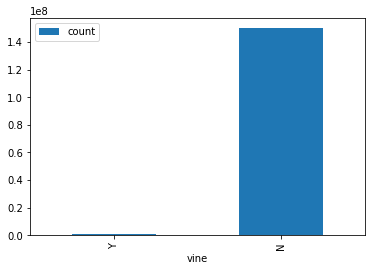

In [173]:
# a simple bar plot
vine_rating.plot(kind='bar',x='vine',y='count')

#### Part f: Top 10 Categories with Most Reviews in 10 years (2006-2015)

In [176]:
# Count reviews by category
top_review = us_reviews.filter('year > 2005').groupBy("product_category").count().sort(col("count").desc()).toPandas()

In [177]:
# find top 10 category
top10_category_review = top_review.head(10)

In [178]:
top10_category_review

,product_category,count
0,Digital_Ebook_Purchase,18871248
1,Books,17046413
2,Wireless,9001657
3,PC,6898971
4,Mobile_Apps,6507959
5,Home,6196626
6,Apparel,5897500
7,Video_DVD,5358907
8,Health_&_Personal_Care,5319835
9,Digital_Video_Download,5115209


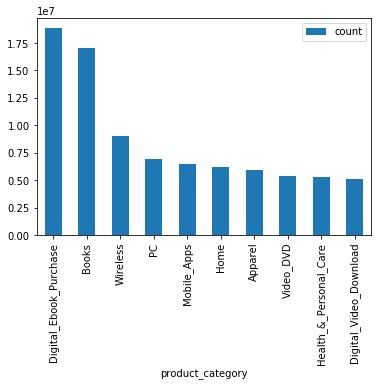

In [179]:
# a simple bar plot
top10_category_review.plot(kind='bar',x='product_category',y='count')

## Part 2: Books Category Exploration

### Part a: Most Review Amount Books

#### Top 10 Reviews books in last 10 years (2006-2015)

In [73]:
# select books with top 10 review amount
spark.sql(
    """select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year > 2005
    group by product_title
    order by review_num DESC
    limit 10""").toPandas()

,product_title,review_num
0,Fifty Shades of Grey: Book One of the Fifty Shades Trilogy (Fifty Shades of Grey Series),18224
1,Gone Girl,11836
2,The Fault in Our Stars,10666
3,"Breaking Dawn (The Twilight Saga, Book 4)",10450
4,Fifty Shades Trilogy (Fifty Shades of Grey / Fifty Shades Darker / Fifty Shades Freed),10274
5,Proof of Heaven: A Neurosurgeon's Journey into the Afterlife,8794
6,Mockingjay (The Hunger Games),7602
7,The Hunger Games (Book 1),7336
8,The Secret,7087
9,The Book Thief,6971


#### Top 5 review books for each year from 2006 to 2015

In [75]:
spark.sql(
    """select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2006
    group by product_title
    order by review_num DESC
    limit 5""").toPandas()

,product_title,review_num
0,A Million Little Pieces,1798
1,The Da Vinci Code,833
2,Marley & Me: Life and Love with the World's Worst Dog,774
3,Godless: The Church of Liberalism,752
4,Cell: A Novel,615


In [76]:
spark.sql(
    """select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2007
    group by product_title
    order by review_num DESC
    limit 5""").toPandas()

,product_title,review_num
0,The Secret,2828
1,Harry Potter and the Deathly Hallows (Book 7),2593
2,A Thousand Splendid Suns,1732
3,The God Delusion,1314
4,"Eat, Pray, Love: One Woman's Search for Everything Across Italy, India and Indonesia",1284


In [77]:
spark.sql(
    """select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2008
    group by product_title
    order by review_num DESC
    limit 5""").toPandas()

,product_title,review_num
0,"Breaking Dawn (The Twilight Saga, Book 4)",6552
1,"A New Earth: Awakening to Your Life's Purpose (Oprah's Book Club, Selection 61)",1892
2,The Shack: Where Tragedy Confronts Eternity,1743
3,"Eat, Pray, Love: One Woman's Search for Everything Across Italy, India and Indonesia",1600
4,"Twilight (The Twilight Saga, Book 1)",1479


In [78]:
spark.sql(
    """select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2009
    group by product_title
    order by review_num DESC
    limit 5""").toPandas()

,product_title,review_num
0,The Lost Symbol,3256
1,"Breaking Dawn (The Twilight Saga, Book 4)",2134
2,Liberty and Tyranny: A Conservative Manifesto,1950
3,The Shack: Where Tragedy Confronts Eternity,1556
4,The Twilight Saga Collection,1518


In [79]:
spark.sql(
    """select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2010
    group by product_title
    order by review_num DESC
    limit 5""").toPandas()

,product_title,review_num
0,The Girl with the Dragon Tattoo (Millennium Series),2224
1,Mockingjay (The Hunger Games),1568
2,The Girl Who Kicked the Hornet's Nest (Millennium Trilogy),1202
3,The Help,1192
4,"The 4-Hour Workweek: Escape 9-5, Live Anywhere, and Join the New Rich",1092


In [80]:
spark.sql(
    """select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2011
    group by product_title
    order by review_num DESC
    limit 5""").toPandas()

,product_title,review_num
0,"The 4 Hour Body: An Uncommon Guide to Rapid Fat Loss, Incredible Sex and Becoming Superhuman",2326
1,A Dance with Dragons (A Song of Ice and Fire),2306
2,Killing Lincoln: The Shocking Assassination that Changed America Forever (Bill O'Reilly's Killin...,2295
3,The Hunger Games (Book 1),2041
4,Heaven is for Real: A Little Boy's Astounding Story of His Trip to Heaven and Back,1595


In [81]:
spark.sql(
    """select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2012
    group by product_title
    order by review_num DESC
    limit 5""").toPandas()

,product_title,review_num
0,Fifty Shades of Grey: Book One of the Fifty Shades Trilogy (Fifty Shades of Grey Series),10516
1,Fifty Shades Trilogy (Fifty Shades of Grey / Fifty Shades Darker / Fifty Shades Freed),3592
2,Gone Girl,3152
3,The Hunger Games (Book 1),2999
4,No Easy Day: The Autobiography of a Navy Seal: The Firsthand Account of the Mission That Killed ...,2574


In [82]:
spark.sql(
    """select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2013
    group by product_title
    order by review_num DESC
    limit 5""").toPandas()

,product_title,review_num
0,Proof of Heaven: A Neurosurgeon's Journey into the Afterlife,4504
1,"A Memory of Light (Wheel of Time, Book 14)",3644
2,Fifty Shades of Grey: Book One of the Fifty Shades Trilogy (Fifty Shades of Grey Series),3490
3,Gone Girl,3426
4,The Legend of Zelda: Hyrule Historia,2956


In [83]:
spark.sql(
    """select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2014
    group by product_title
    order by review_num DESC
    limit 5""").toPandas()

,product_title,review_num
0,The Fault in Our Stars,5576
1,Gone Girl,3534
2,The Goldfinch: A Novel (Pulitzer Prize for Fiction),3308
3,The Book Thief,2476
4,Allegiant (Divergent Series),2404


In [84]:
spark.sql(
    """select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2015
    group by product_title
    order by review_num DESC
    limit 5""").toPandas()

,product_title,review_num
0,The Girl on the Train,5254
1,Go Set a Watchman: A Novel,3930
2,The Life-Changing Magic of Tidying Up: The Japanese Art of Decluttering and Organizing,3628
3,All the Light We Cannot See,3338
4,Grey: Fifty Shades of Grey as Told by Christian (Fifty Shades of Grey Series),3170


### Part b: Top Rated Books

#### Top 10 rating books in last 10 years (2006-2015)

In [86]:
# Select top rated books with top100 review amount
spark.sql(
    """SELECT t1.product_title, t1.review_num, t2.rating
FROM 
    (select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year > 2005 
    group by product_title 
    order by review_num DESC 
    limit 100) t1
LEFT JOIN
    (select product_title, avg(star_rating) as rating from ustbl 
    group by product_title) t2
ON (t1.product_title = t2.product_title)
ORDER BY t2.rating DESC, t1.review_num DESC LIMIT 10""").toPandas()

,product_title,review_num,rating
0,Jesus Calling: Enjoying Peace in His Presence,5324,4.881757
1,"Oh, the Places You'll Go!",3539,4.860881
2,The Legend of Zelda: Hyrule Historia,4654,4.845724
3,Wonder,3319,4.844796
4,Being Mortal: Medicine and What Matters in the End,2534,4.820942
5,Humans of New York,3898,4.816297
6,Rush Revere and the Brave Pilgrims: Time-Travel Adventures with Exceptional Americans,4194,4.790819
7,"Unbroken: A World War II Story of Survival, Resilience, and Redemption",6439,4.788344
8,A Game of Thrones / A Clash of Kings / A Storm of Swords / A Feast of Crows / A Dance with Dragons,3548,4.763811
9,The 5 Love Languages: The Secret to Love That Lasts,4454,4.760772


#### Top 5 rated books for each year from 2006 to 2015

In [87]:
spark.sql(
    """SELECT t1.product_title, t1.review_num, t2.rating
FROM 
    (select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2006 
    group by product_title 
    order by review_num DESC 
    limit 100) t1
LEFT JOIN
    (select product_title, avg(star_rating) as rating from ustbl 
    group by product_title) t2
ON (t1.product_title = t2.product_title)
ORDER BY t2.rating DESC, t1.review_num DESC LIMIT 5""").toPandas()

,product_title,review_num,rating
0,"For Laci: A Mother's Story of Love, Loss, and Justice",223,4.817204
1,Team of Rivals: The Political Genius of Abraham Lincoln,308,4.730311
2,The Five Love Languages: How to Express Heartfelt Commitment to Your Mate,156,4.709896
3,Night (Night),408,4.668046
4,To Kill a Mockingbird,204,4.661871


In [88]:
spark.sql(
    """SELECT t1.product_title, t1.review_num, t2.rating
FROM 
    (select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2007 
    group by product_title 
    order by review_num DESC 
    limit 100) t1
LEFT JOIN
    (select product_title, avg(star_rating) as rating from ustbl 
    group by product_title) t2
ON (t1.product_title = t2.product_title)
ORDER BY t2.rating DESC, t1.review_num DESC LIMIT 5""").toPandas()

,product_title,review_num,rating
0,Vegan Cupcakes Take Over the World: 75 Dairy-Free Recipes for Cupcakes that Rule,188,4.803810
1,The Laws of Thinking: 20 Secrets to Using the Divine Power of Your Mind to Manifest Prosperity,202,4.761194
2,Because They Hate: A Survivor of Islamic Terror Warns America,202,4.719764
3,The Invention of Hugo Cabret,200,4.709924
4,The Five Love Languages: How to Express Heartfelt Commitment to Your Mate,250,4.709896


In [89]:
spark.sql(
    """SELECT t1.product_title, t1.review_num, t2.rating
FROM 
    (select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2008 
    group by product_title 
    order by review_num DESC 
    limit 100) t1
LEFT JOIN
    (select product_title, avg(star_rating) as rating from ustbl 
    group by product_title) t2
ON (t1.product_title = t2.product_title)
ORDER BY t2.rating DESC, t1.review_num DESC LIMIT 5""").toPandas()

,product_title,review_num,rating
0,Star Wars: A Pop-Up Guide to the Galaxy,256,4.846154
1,The Complete Calvin and Hobbes [Box Set],211,4.819987
2,Diary of a Wimpy Kid Rodrick Rules,207,4.733181
3,The Twilight Saga Collection,296,4.714131
4,Midnights with the Mystic: A Little Guide to Freedom and Bliss,295,4.708122


In [90]:
spark.sql(
    """SELECT t1.product_title, t1.review_num, t2.rating
FROM 
    (select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2009 
    group by product_title 
    order by review_num DESC 
    limit 100) t1
LEFT JOIN
    (select product_title, avg(star_rating) as rating from ustbl 
    group by product_title) t2
ON (t1.product_title = t2.product_title)
ORDER BY t2.rating DESC, t1.review_num DESC LIMIT 5""").toPandas()

,product_title,review_num,rating
0,"The Last Olympian (Percy Jackson and the Olympians, Book 5)",254,4.844170
1,"Mastering the Art of French Cooking, Vol. 1",238,4.828816
2,Diary of a Wimpy Kid: The Last Straw (Book 3),280,4.755448
3,Team of Rivals: The Political Genius of Abraham Lincoln,222,4.730311
4,Sookie Stackhouse Dead Until Dark; Living Dead in Dallas; Club Dead; Dead to the World; Dead as ...,698,4.729792


In [91]:
spark.sql(
    """SELECT t1.product_title, t1.review_num, t2.rating
FROM 
    (select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2010 
    group by product_title 
    order by review_num DESC 
    limit 100) t1
LEFT JOIN
    (select product_title, avg(star_rating) as rating from ustbl 
    group by product_title) t2
ON (t1.product_title = t2.product_title)
ORDER BY t2.rating DESC, t1.review_num DESC LIMIT 5""").toPandas()

,product_title,review_num,rating
0,Aspire: Discovering Your Purpose Through the Power of Words,466,4.898734
1,With the Old Breed: At Peleliu and Okinawa,266,4.873105
2,Unlocked,587,4.816216
3,The Twilight Saga Collection,379,4.714131
4,The Pioneer Woman Cooks: Recipes from an Accidental Country Girl,304,4.712772


In [92]:
spark.sql(
    """SELECT t1.product_title, t1.review_num, t2.rating
FROM 
    (select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2011 
    group by product_title 
    order by review_num DESC 
    limit 100) t1
LEFT JOIN
    (select product_title, avg(star_rating) as rating from ustbl 
    group by product_title) t2
ON (t1.product_title = t2.product_title)
ORDER BY t2.rating DESC, t1.review_num DESC LIMIT 5""").toPandas()

,product_title,review_num,rating
0,Until Tuesday: A Wounded Warrior and the Golden Retriever Who Saved Him,416,4.808532
1,"Unbroken: A World War II Story of Survival, Resilience, and Redemption",1069,4.788344
2,The 5 Love Languages: The Secret to Love That Lasts,282,4.760772
3,Learning (Bailey Flanigan Series),291,4.751429
4,The Hunger Games Trilogy Boxed Set,534,4.743872


In [93]:
spark.sql(
    """SELECT t1.product_title, t1.review_num, t2.rating
FROM 
    (select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2012 
    group by product_title 
    order by review_num DESC 
    limit 100) t1
LEFT JOIN
    (select product_title, avg(star_rating) as rating from ustbl 
    group by product_title) t2
ON (t1.product_title = t2.product_title)
ORDER BY t2.rating DESC, t1.review_num DESC LIMIT 5""").toPandas()

,product_title,review_num,rating
0,Jesus Calling: Enjoying Peace in His Presence,366,4.881757
1,Fearless: The Undaunted Courage and Ultimate Sacrifice of Navy SEAL Team SIX Operator Adam Brown,682,4.873696
2,Wonder,369,4.844796
3,Until Tuesday: A Wounded Warrior and the Golden Retriever Who Saved Him,365,4.808532
4,"Unbroken: A World War II Story of Survival, Resilience, and Redemption",664,4.788344


In [94]:
spark.sql(
    """SELECT t1.product_title, t1.review_num, t2.rating
FROM 
    (select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2013 
    group by product_title 
    order by review_num DESC 
    limit 100) t1
LEFT JOIN
    (select product_title, avg(star_rating) as rating from ustbl 
    group by product_title) t2
ON (t1.product_title = t2.product_title)
ORDER BY t2.rating DESC, t1.review_num DESC LIMIT 5""").toPandas()

,product_title,review_num,rating
0,"Goodnight, Goodnight Construction Site",607,4.890690
1,Jesus Calling: Enjoying Peace in His Presence,1505,4.881757
2,Fearless: The Undaunted Courage and Ultimate Sacrifice of Navy SEAL Team SIX Operator Adam Brown,716,4.873696
3,Go Pro: 7 Steps to Becoming a Network Marketing Professional,775,4.868534
4,"Oh, the Places You'll Go!",820,4.860881


In [95]:
spark.sql(
    """SELECT t1.product_title, t1.review_num, t2.rating
FROM 
    (select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2014 
    group by product_title 
    order by review_num DESC 
    limit 100) t1
LEFT JOIN
    (select product_title, avg(star_rating) as rating from ustbl 
    group by product_title) t2
ON (t1.product_title = t2.product_title)
ORDER BY t2.rating DESC, t1.review_num DESC LIMIT 5""").toPandas()

,product_title,review_num,rating
0,Rush Revere and the American Revolution: Time-Travel Adventures With Exceptional Americans,687,4.895547
1,Rush Revere and the First Patriots: Time-Travel Adventures With Exceptional Americans,1372,4.883428
2,Jesus Calling: Enjoying Peace in His Presence,1759,4.881757
3,The Promise of a Pencil: How an Ordinary Person Can Create Extraordinary Change,940,4.865248
4,"Oh, the Places You'll Go!",1007,4.860881


In [96]:
spark.sql(
    """SELECT t1.product_title, t1.review_num, t2.rating
FROM 
    (select product_title, count(*) as review_num from ustbl 
    where product_category = 'Books' and year = 2015 
    group by product_title 
    order by review_num DESC 
    limit 100) t1
LEFT JOIN
    (select product_title, avg(star_rating) as rating from ustbl 
    group by product_title) t2
ON (t1.product_title = t2.product_title)
ORDER BY t2.rating DESC, t1.review_num DESC LIMIT 5""").toPandas()

,product_title,review_num,rating
0,Little Blue Truck Board Book,867,4.903487
1,Rush Revere and the American Revolution: Time-Travel Adventures With Exceptional Americans,865,4.895547
2,Jesus Calling: Enjoying Peace in His Presence,1189,4.881757
3,Minecraft: The Complete Handbook Collection,625,4.862554
4,"Oh, the Places You'll Go!",1174,4.860881


### Part c: Average Helpful Vote Amount by Rating

In [68]:
# calculate the average helpful vote amount, total vote amount, and the percetage of helpful vote by rating
spark.sql(
    """select star_rating, avg(helpful_votes) as avg_helpful, avg(total_votes) as avg_ttl, avg(helpful_votes)/avg(total_votes) as percentage from ustbl 
    where product_category = 'Books' and year > 2005
    group by star_rating
    order by star_rating DESC""").toPandas()

,star_rating,avg_helpful,avg_ttl,percentage
0,5,2.139348,2.715336,0.787876
1,4,2.249199,2.877892,0.781544
2,3,3.335227,4.862013,0.685977
3,2,4.642029,7.615942,0.609515
4,1,9.928320,20.854289,0.476080


## Part 3: Customer ID Analysis

Review amount from same customer to same product.

In [180]:
us_reviews.groupBy('customer_id','product_id').agg(F.avg("star_rating"), F.sum("helpful_votes"), F.count("*").alias('count')).sort(col("count").desc()).show()

+-----------+----------+------------------+------------------+-----+
|customer_id|product_id|  avg(star_rating)|sum(helpful_votes)|count|
+-----------+----------+------------------+------------------+-----+
|   38118182|B00003CXTG| 4.230769230769231|               104|  260|
|   33132919|B0000TB03W|               5.0|                12|  220|
|   29088361|B0000DD7LB| 4.967213114754099|               604|  122|
|   23974294|B0000TB03W|               5.0|                 8|  114|
|   50432389|B0000DD7LB|               5.0|               258|   98|
|   50440254|B00004ZAV3|               5.0|               182|   94|
|   32330663|B0000D1FI7|               5.0|               196|   82|
|   43622173|B00005JXQU| 4.975609756097561|                53|   82|
|   23999101|B0000TB03W|               5.0|                72|   76|
|   50891233|B0000TB03W|               5.0|                 2|   74|
|   23969117|B0000TB03W| 4.181818181818182|                48|   66|
|   52773547|B00004SCX6|          

Total helpful vote by customer.

In [182]:
us_reviews.groupBy('customer_id').agg(F.sum("helpful_votes").alias('totalvotes')).sort(col("totalvotes").desc()).show()

+-----------+----------+
|customer_id|totalvotes|
+-----------+----------+
|   50122160|    260723|
|    9286343|    143066|
|   44834233|    123936|
|   50732546|    122651|
|   50881246|    101983|
|   52496677|    101074|
|   52615377|     93564|
|   50913245|     87197|
|   52500542|     82237|
|   53017806|     75926|
|   30669680|     75359|
|   52048190|     73260|
|   52938899|     70870|
|   53090839|     67429|
|   39134375|     66090|
|   50199793|     62571|
|   24936774|     61694|
|   51835976|     60692|
|   13376158|     56667|
|   16378095|     56329|
+-----------+----------+
only showing top 20 rows



## Part 4: Text Classification Models

### Data Preparation

In [100]:
# subset and focus on books category
books = us_reviews.filter(us_reviews.product_category == 'Books')

In [120]:
# prepara dataset and select desired columns
data = books.select(['star_rating','review_body'])

In [121]:
# convert star_rating format from int to string
from pyspark.sql.types import *
data = data.withColumn("star_rating", data["star_rating"].cast(StringType()))

In [122]:
# show data schema
data.printSchema()

root
 |-- star_rating: string (nullable = true)
 |-- review_body: string (nullable = true)



In [123]:
# drop null values
data = data.na.drop()

In [124]:
# show first 5 rows of dataset
data.show(5)

+-----------+--------------------+
|star_rating|         review_body|
+-----------+--------------------+
|          5|After attending a...|
|          4|Krauss traces the...|
|          4|Rebecca, a dental...|
|          5|\\"BARED TO YOU\\...|
|          5|Good characters a...|
+-----------+--------------------+
only showing top 5 rows



### Model Pipeline

In [125]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import *

In [126]:
#data = data.sample(False, 0.0005, 12345)

In [127]:
#data.count()

In [128]:
# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="review_body", outputCol="words", pattern="\\W")

In [129]:
# stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
add_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/hadoop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [130]:
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

In [131]:
# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=0.1)

### StringIndexer and Pipeline

In [132]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
label_stringIdx = StringIndexer(inputCol = "star_rating", outputCol = "label")

In [133]:
# Create pipeline
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

In [134]:
# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
dataset.show(5)

+-----------+--------------------+--------------------+--------------------+--------------------+-----+
|star_rating|         review_body|               words|            filtered|            features|label|
+-----------+--------------------+--------------------+--------------------+--------------------+-----+
|          5|After attending a...|[after, attending...|[attending, qigon...|(30,[0,1,2,11,15,...|  0.0|
|          4|Krauss traces the...|[krauss, traces, ...|[krauss, traces, ...|(30,[1,3,4,6,10,1...|  1.0|
|          4|Rebecca, a dental...|[rebecca, a, dent...|[rebecca, dental,...|(30,[0,1,3,4,5,7,...|  1.0|
|          5|\\"BARED TO YOU\\...|[bared, to, you, ...|[bared, sizzling,...|(30,[5,12,14,20,2...|  0.0|
|          5|Good characters a...|[good, characters...|[good, characters...|(30,[0,8,9,10,19,...|  0.0|
+-----------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



### Build Model

In [135]:
# set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 12345)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 14258199
Test Dataset Count: 6111743


#### Logistic Regression

In [136]:
# Build logistic Regression Model
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("star_rating","review_body","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+-----------+------------------------------+------------------------------+-----+----------+
|star_rating|                   review_body|                   probability|label|prediction|
+-----------+------------------------------+------------------------------+-----+----------+
|          5|I did not read this book. I...|[0.9999995825196806,2.47699...|  0.0|       0.0|
|          5|great bookgreat book great ...|[0.9999979795372991,1.99908...|  0.0|       0.0|
|          5|great bookgreat book great ...|[0.9999979795372991,1.99908...|  0.0|       0.0|
|          5|The book is the same book t...|[0.9999895016539463,9.06772...|  0.0|       0.0|
|          5|great bookgreat book great ...|[0.9999643352467107,3.46101...|  0.0|       0.0|
|          5|great bookgreat book great ...|[0.9999643352467107,3.46101...|  0.0|       0.0|
|          5|great bookgreat book great ...|[0.9999643352467107,3.46101...|  0.0|       0.0|
|          5|great bookgreat book great ...|[0.9999643352467107,3.4610

In [137]:
# Check the evaluation of logistic regression model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.5286045185106201

#### Naive Bayes

In [139]:
# Build Naive Bayes Model
nb = NaiveBayes(smoothing=1)
model = nb.fit(trainingData)
predictions = model.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("star_rating","review_body","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+-----------+------------------------------+------------------------------+-----+----------+
|star_rating|                   review_body|                   probability|label|prediction|
+-----------+------------------------------+------------------------------+-----+----------+
|          5|The book is the same book t...|[1.0,4.975443698889049E-22,...|  0.0|       0.0|
|          5|great bookgreat book great ...|[1.0,1.254473009875087E-23,...|  0.0|       0.0|
|          5|great bookgreat book great ...|[1.0,1.254473009875087E-23,...|  0.0|       0.0|
|          5|great bookgreat book great ...|[1.0,1.254473009875087E-23,...|  0.0|       0.0|
|          5|great bookgreat book great ...|[1.0,1.254473009875087E-23,...|  0.0|       0.0|
|          5|great bookgreat book great ...|[1.0,1.254473009875087E-23,...|  0.0|       0.0|
|          5|great bookgreat book great ...|[1.0,1.254473009875087E-23,...|  0.0|       0.0|
|          5|great bookgreat book great ...|[1.0,6.802480453381727E-31

In [140]:
# Check the evaluation of naive bayes model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.551036634353428

#### Random Forest

In [141]:
# Build Random Forest Model
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)
# Train model with Training Data
rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("star_rating","review_body","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+-----------+------------------------------+------------------------------+-----+----------+
|star_rating|                   review_body|                   probability|label|prediction|
+-----------+------------------------------+------------------------------+-----+----------+
|          1|#1  Glad I only spent 1 cen...|[0.658958212983804,0.171267...|  3.0|       0.0|
|          1|&quot;And many false prophe...|[0.658958212983804,0.171267...|  3.0|       0.0|
|          1|&quot;I don't wanna know yo...|[0.658958212983804,0.171267...|  3.0|       0.0|
|          1|&quot;Let a Lover of Truth ...|[0.658958212983804,0.171267...|  3.0|       0.0|
|          1|&quot;Unfortunate slickness...|[0.658958212983804,0.171267...|  3.0|       0.0|
|          1|&quot;Well-behaved women ra...|[0.658958212983804,0.171267...|  3.0|       0.0|
|          1|'\\"Begin at the beginning,...|[0.658958212983804,0.171267...|  3.0|       0.0|
|          1|'\\"You bugger,\\" she spat...|[0.658958212983804,0.17126

In [142]:
# Check the evaluation of random forest model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.5237310182460008

### Stop spark

In [184]:
spark.stop()